# `Challenge Deep Learning`

## `Consigne`

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images de champignons.
Le jeu de données proposé comprend 3 classes balancées

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Vous devez prendre en compte la spécificité des données (peu d'exemples, images de tailles différentes,...) pour construire vos jeux d'apprentissage et de test.

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur une base que nous conservons, pour voir si les résultats que vous proposez sont reproductibles.

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous **expliquerez votre démarche**, **justifierez vos choix**, **commenterez vos expérimentations et vos résultats**.

La notation sera construite de la manière suivante :
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test.

Le notebook sera déposé sur la plateforme moodle du cours.

# ``Imports``

In [83]:
# Matplotlib
import matplotlib.pyplot as plt

# Numpy
import numpy as np

# Pandas
import pandas as pd

# Keras
from keras.applications import EfficientNetB7, ResNet50,DenseNet121, EfficientNetB0
from keras.layers import Dense, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Keras Tuner
from keras_tuner import RandomSearch

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


import logging
tf.get_logger().setLevel(logging.ERROR)

In [84]:
!pip freeze > "requirements.txt"

Note: you may need to restart the kernel to use updated packages.


# ``Travail``

## ``Choix des modèles``


![model](img/model.png)

## `Pré-traitement des données`


Dans un premier temps, nous allons préparer les données à l'entraînement.

Nous parcourons la structure des répertoires pour identifier les images des champignons (amanita, crimini, oyster) à récupérer pour notre dataset.

In [85]:
import pathlib

path = "datasets/mushrooms"
dset_dir = pathlib.Path(path)

# Count all images with .jpg or .png extensions
image_count = len(list(dset_dir.glob('*/*.[jp][np]g')))

print(f"Nombre d'images : {image_count}")

Nombre d'images : 2883


Cela nous permet de vérifier l'intégralité du dataset et d'évaluer la taille totale des données disponibles ainsi que leur classes.

In [86]:
batch_size = 48
img_height = 224
img_width  = 224
seed = 4785

num_images = 5736
steps_per_epoch = num_images // batch_size

print(f"Steps per epoch: {steps_per_epoch}")

Steps per epoch: 119


Nous procédons ensuite à la division du dataset en ensemble d' (``train_dset``), de validation (``val_dset``), et de tests (plus loin dans le rapport : ``test_dset``) pour entrâiner le réseau de neurone. Les images d'entrainement et de validation doivent donc être placés dans `datasets/mushrooms`. Les images de tests doivent quant à elle se situer dans ``tests/`` (agrémenter le dataset de tests au besoin)

![arb](img/arborescence.png)

In [87]:
train_dset = tf.keras.utils.image_dataset_from_directory(
    dset_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2883 files belonging to 3 classes.
Using 2307 files for training.


In [88]:
val_dset = tf.keras.utils.image_dataset_from_directory(
    dset_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2883 files belonging to 3 classes.
Using 576 files for validation.


In [89]:
class_names = train_dset.class_names
print(class_names)

['amanita', 'crimini', 'oyster']


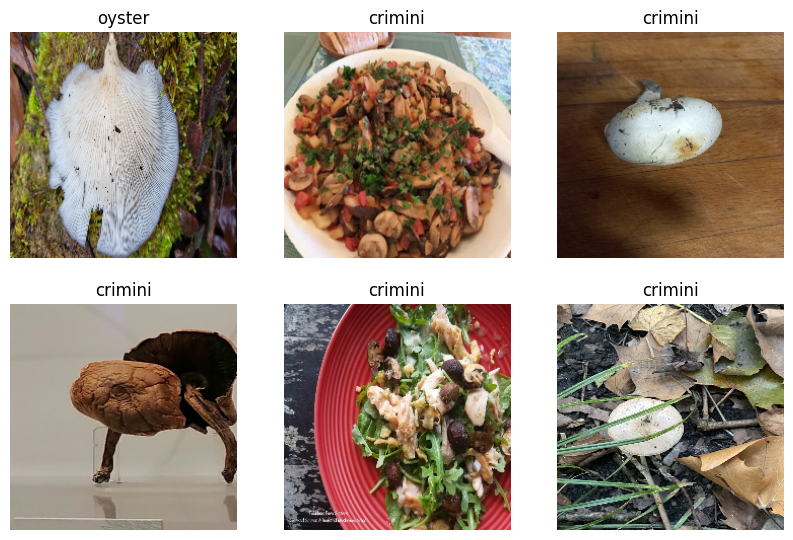

In [90]:
plt.figure(figsize=(10,10))
for images, labels in train_dset.take(1):
    for i in range(6):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# `Modèle de réseaux de neurones`


## ``ResNet50``
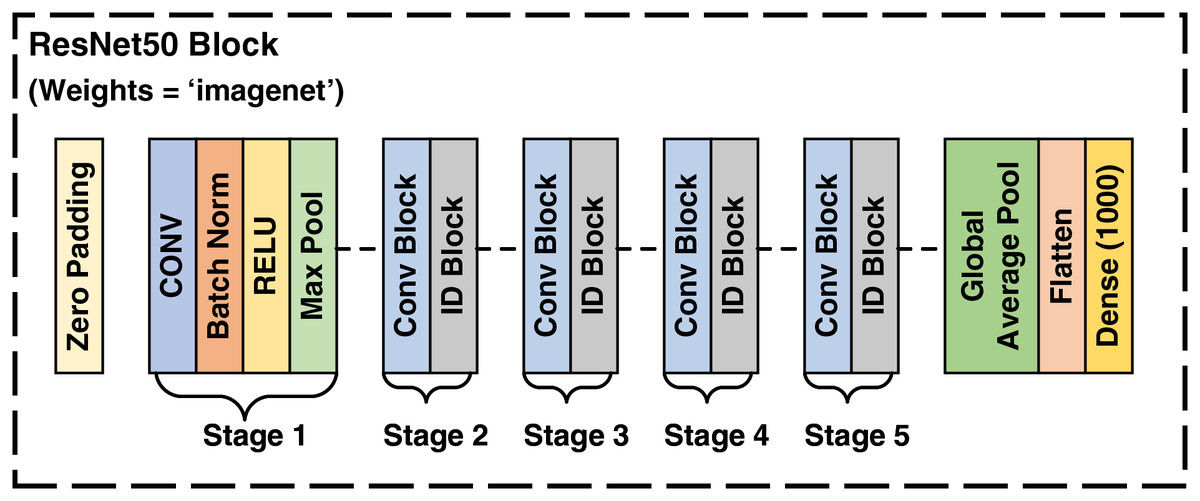

ResNet50 (Residual Network avec 50 couches) est un modèle de réseau de neurones profond.

Il fait partie de la famille des architectures ResNet, introduites par Kaiming He et al. en 2015.

L'une des caractéristiques clés de ResNet est l'utilisation de connexions résiduelles (ou skip connections), qui permettent aux gradients de se propager plus efficacement à travers le réseau en évitant le problème de vanishing gradient.

ResNet50 est composé de 50 couches de profondeur, incluant des convolutions, des couches de normalisation et des fonctions d'activation, avec des blocs résiduels pour améliorer la capacité d'apprentissage.

``Pourquoi ce choix ?``

ResNet50 est un modèle éprouvé qui a remporté des compétitions comme ImageNet en raison de sa capacité à capturer des caractéristiques complexes dans les images.

Ainsi, ce modèle peut être initialisé avec des poids pré-entraînés sur ImageNet, une large base de données d'images. Cela permet un transfert d'apprentissage, c'est-à-dire de réutiliser des caractéristiques générales d'extraction d'images (textures, contours, couleurs) pour accélérer et améliorer les performances lors de l'entraînement sur un dataset spécifique comme celui des champignons.

In [91]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_dset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


Les données d'entrée du réseau de neurones sont correctement normalisées.

La normalisation améliore la stabilité de l'optimisation et accélère la convergence du modèle.

#### ``Augmentation du jeu de données``

L'augmentation de données est essentielle dans les tâches de vision par ordinateur, surtout lorsque le dataset est limité.

In [92]:
from keras import Input

img_height = 224
img_width = 224

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", seed=47823),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.5),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.3)
])

input_layer = Input(shape=(img_height, img_width, 3))
augmented_images = data_augmentation(input_layer)


Ce code permet ici de générer de nouvelles images à partir de l'ensemble existant en appliquant des transformations (rotation, zoom, flip horizontal & vertical) à l'ensemble de données.

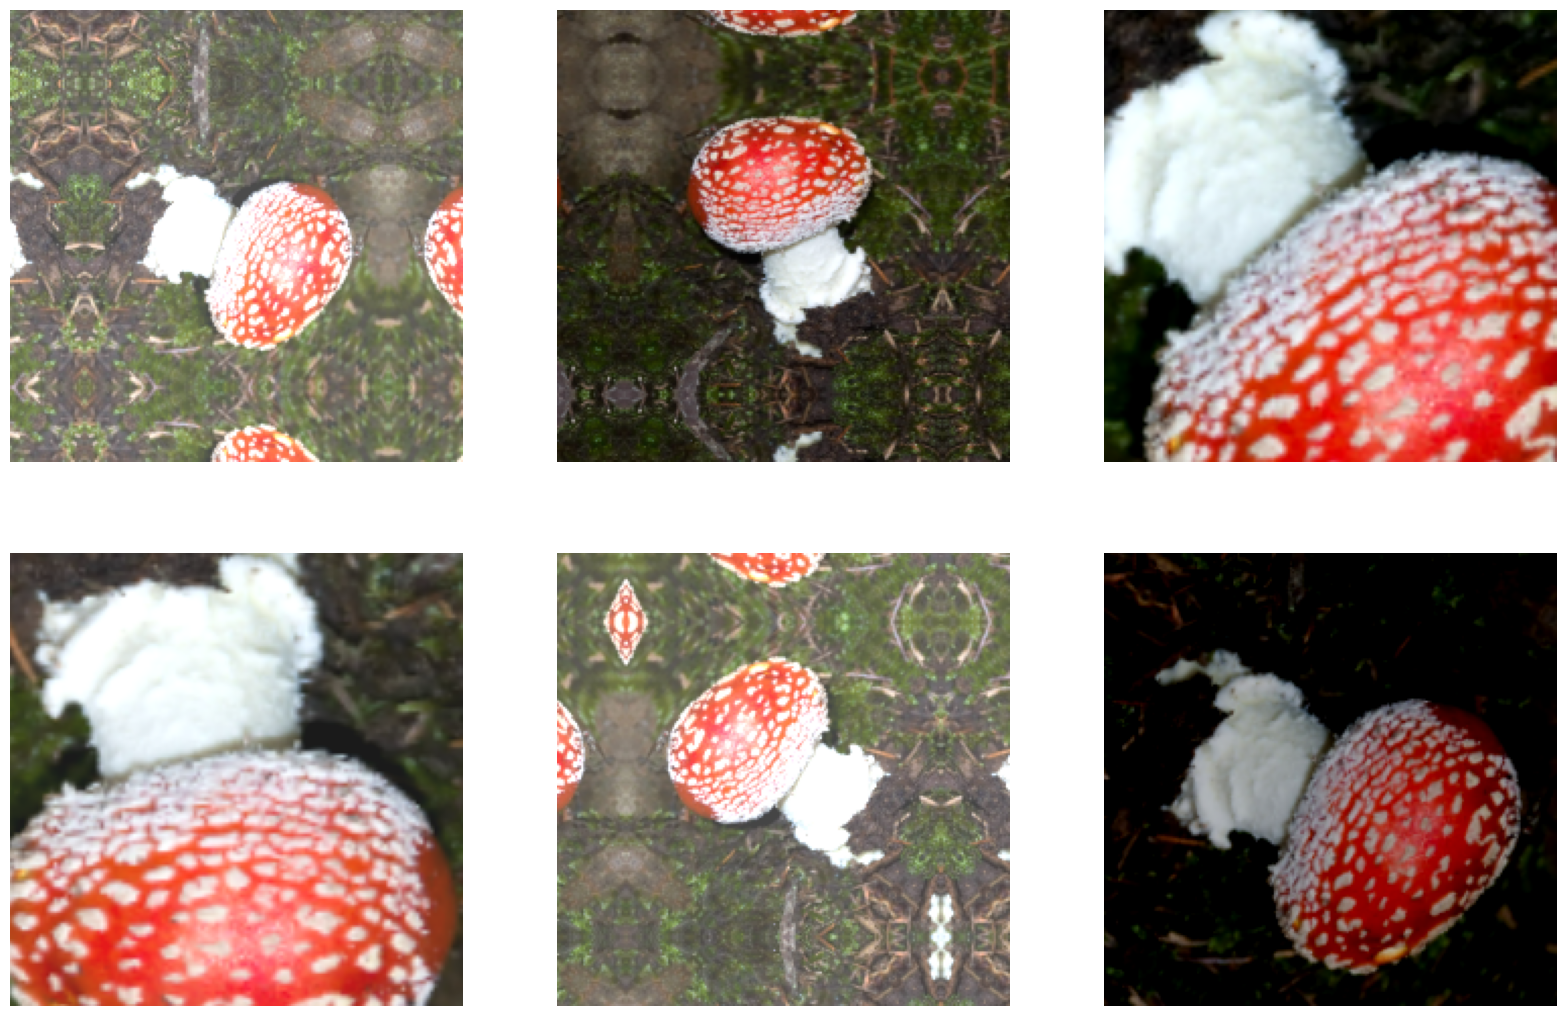

In [93]:
plt.figure(figsize=(20,20))
for images, _ in train_dset.take(1):
    for i in range(6):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### ``Implémentation du modèle``

In [94]:
# Num. classes
num_classes = len(class_names)

# Modèle ResNet50 pré-entraîné avec les poids d'ImageNet, sans les couches de sortie (include_top=False)
resnet_model = ResNet50(weights="imagenet", include_top=False)

for layer in resnet_model.layers[:100]:
    layer.trainable = False

# Définition du modèle final avec les étapes suivantes :
res_net_model = Sequential([
    data_augmentation,
    resnet_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Compilation du modèle avec :
# Optimiseur "adam"
# Fonction de perte "sparse_categorical_crossentropy"
# Mesure de précision comme métrique d'évaluation
res_net_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [95]:
res_net_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

res_net_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 19,715,587 (75.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [96]:
checkpoint = ModelCheckpoint("Model(ResNet50).h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              mode='max', cooldown=2, patience=3, min_lr=0)


In [97]:
epochs = 5

history = res_net_model.fit(
    train_dset,
    validation_data=val_dset,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/5
 1/49 ━━━━━━━━━━━━━━━━━━━━ 13:02 16s/step - accuracy: 0.2917 - loss: 1.2662

C:\Users\reynalde\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.6359 - loss: 0.7752 - val_accuracy: 0.7778 - val_loss: 0.8878 - learning_rate: 1.0000e-04
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.8723 - loss: 0.3476 - val_accuracy: 0.8368 - val_loss: 0.4973 - learning_rate: 1.0000e-04
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.8976 - loss: 0.2631 - val_accuracy: 0.8212 - val_loss: 0.5286 - learning_rate: 1.0000e-04
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9136 - loss: 0.2319 - val_accuracy: 0.9010 - val_loss: 0.2906 - learning_rate: 1.0000e-04
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.9306 - loss: 0.1827 - val_accuracy: 0.8958 - val_loss: 0.3585 - learning_rate: 1.0000e-04


In [98]:
def plot_images_grid_predicted_keras(dataset, model, classes, num_images=30):
    fig, axes = plt.subplots(6, 5, figsize=(10, 10))
    axes = axes.flatten()

    images_displayed = 0

    for batch_images, batch_labels in dataset:
        for img, label in zip(batch_images, batch_labels):
            if images_displayed >= num_images:
                break

            label = int(label.numpy())
            true_label = classes[label]

            input_img = tf.expand_dims(img, axis=0)
            pred = model.predict(input_img, verbose=0)
            pred_label = classes[np.argmax(pred)]

            color = "green" if pred_label == true_label else "red"
            ax = axes[images_displayed]
            ax.imshow(tf.keras.utils.array_to_img(img))
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color=color)
            ax.axis("off")

            images_displayed += 1

        if images_displayed >= num_images:
            break

    plt.tight_layout()
    plt.show()

Found 33 files belonging to 3 classes.


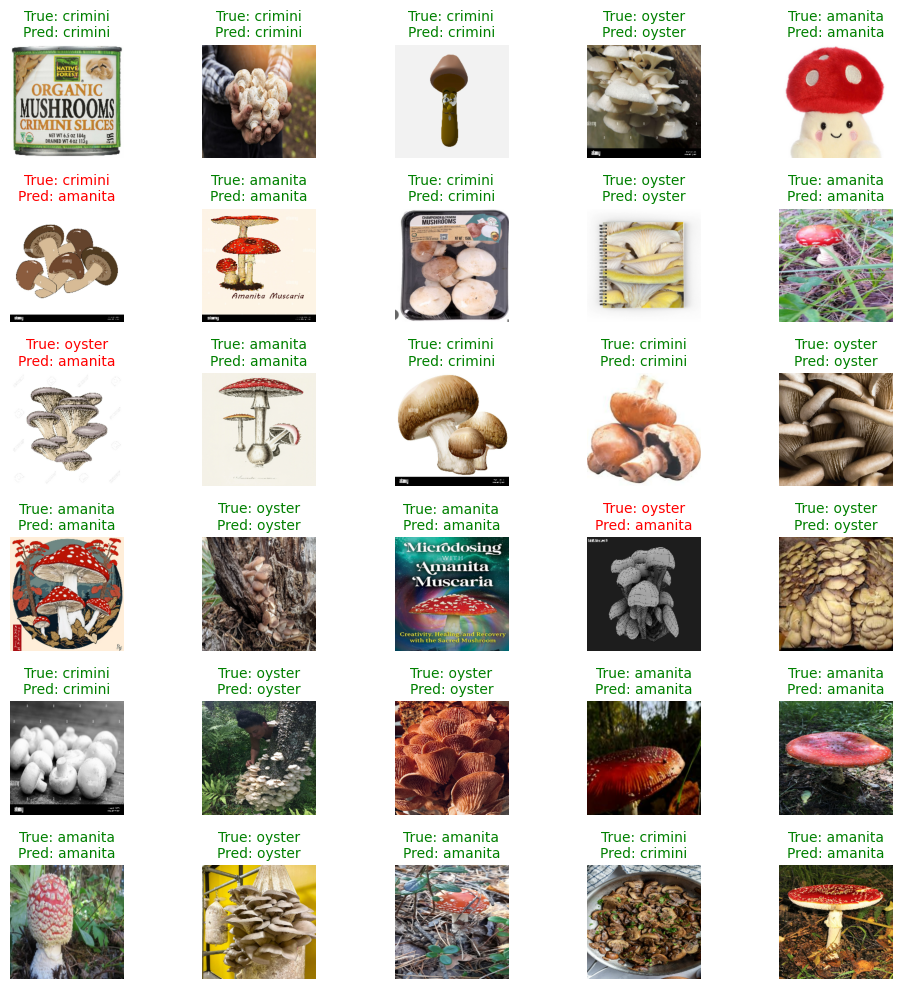

In [99]:
path = "tests"
test_dset_dir = pathlib.Path(path)

test_dset = tf.keras.utils.image_dataset_from_directory(
    test_dset_dir,
    shuffle=True,
    image_size=(img_height, img_width)
)

plot_images_grid_predicted_keras(test_dset, res_net_model, classes=class_names)

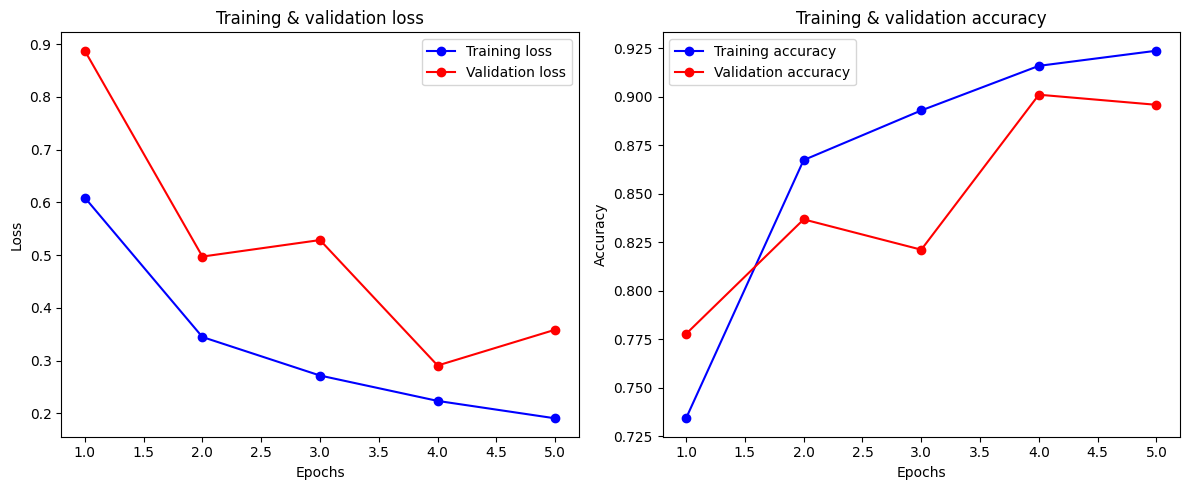

In [100]:
def plot_learning_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Tracer la perte
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training & validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Tracer la précision
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
    plt.title('Training & validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

In [101]:
data = []
for layer in resnet_model.layers:
    weights = layer.get_weights()
    if weights:
        for i, w in enumerate(weights):
            data.append({"Layer Name": layer.name, "Weight n°": i+1, "Shape": w.shape})


df = pd.DataFrame(data)
print(df)

df.to_csv("resnet_model_weights.csv", index=False)

              Layer Name  Weight n°          Shape
0             conv1_conv          1  (7, 7, 3, 64)
1             conv1_conv          2          (64,)
2               conv1_bn          1          (64,)
3               conv1_bn          2          (64,)
4               conv1_bn          3          (64,)
..                   ...        ...            ...
313  conv5_block3_3_conv          2        (2048,)
314    conv5_block3_3_bn          1        (2048,)
315    conv5_block3_3_bn          2        (2048,)
316    conv5_block3_3_bn          3        (2048,)
317    conv5_block3_3_bn          4        (2048,)

[318 rows x 3 columns]


### ``EfficientNetB7``

![enmodel](img/efficient-net.png)

``Pourquoi ce choix ?``

EfficientNet est une famille de modèles de classification d'images qui ont été conçus pour obtenir une excellente précision avec un coût computationnel réduit.

Le modèle EfficientNetB0 a atteint une précision top-1 de 77,1 % et une précision top-5 de 93,3 %, avec seulement 5,3 millions de paramètres. (https://arxiv.org/abs/1905.11946)

En termes de vitesse d'entraînement, une étude a démontré qu'il est possible d'entraîner EfficientNet-B0 sur ImageNet pour atteindre une précision de 83 % en environ une heure en utilisant des ressources de calcul intensives, telles que des pods TPU-v3 avec 2048 cœurs (https://arxiv.org/abs/2011.00071?utm_source)

 EfficientNet étant déjà optimisé pour minimiser le nombre de paramètres, l'utilisation de KerasTuner ici apporte un gain supplémentaire en précision.

In [104]:
def build_model(hp):
    data_augmentation = Sequential([
        RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
        RandomRotation(0.3),
        RandomZoom(0.2),
        RandomContrast(0.3)
    ])

    # Modèle EfficientNetB0 pré-entraîné
    efficientnet_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
    for layer in efficientnet_model.layers[:100]:
        layer.trainable = False

    # Construction du modèle
    model = Sequential([
        data_augmentation,
        efficientnet_model,
        GlobalAveragePooling2D(),
        Dense(
            hp.Int('units', min_value=64, max_value=256, step=64),
            activation=hp.Choice('activation', ['relu', 'tanh'])
        ),
        Dense(num_classes, activation="softmax")
    ])

    # Compilation du modèle
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Instanciation de Keras Tuner avec RandomSearch
# = explore les combinaisons d'hyperparamètres de manière aléatoire
tuner = RandomSearch(
    build_model,
    # Maximiser la précision de validation
    objective='val_accuracy',
    # Nombre maximal de configurations testées
    max_trials=10,
     # Nombre d'exécutions par configuration
    executions_per_trial=1,
    # Stockage des résultats
    directory="keras_tuner_results")

C:\Users\reynalde\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [105]:
checkpoint = ModelCheckpoint("Model(KerasTuner).h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_freq="epoch")

tuner.search(train_dset, validation_data=val_dset, epochs=5)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construire le modèle avec les meilleurs hyperparamètres trouvés
efficient_net_model = tuner.hypermodel.build(best_hps)

# Entraîner le modèle optimisé
history = efficient_net_model.fit(train_dset, verbose=1, validation_data=val_dset, callbacks=[checkpoint, early_stopping, reduce_lr], epochs=5)

Trial 10 Complete [00h 06m 42s]
val_accuracy: 0.5416666865348816

Best val_accuracy So Far: 0.9322916865348816
Total elapsed time: 01h 07m 13s
Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6056 - loss: 0.8321
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to Model(KerasTuner).h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.6082 - loss: 0.8283 - val_accuracy: 0.8750 - val_loss: 0.3400 - learning_rate: 1.0000e-04
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8759 - loss: 0.3402
Epoch 2: val_accuracy improved from 0.87500 to 0.91493, saving model to Model(KerasTuner).h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8761 - loss: 0.3399 - val_accuracy: 0.9149 - val_loss: 0.2601 - learning_rate: 1.0000e-04
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9050 - loss: 0.2569
Epoch 3: val_accuracy improved from 0.91493 to 0.92535, saving model to Model(KerasTuner).h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9051 - loss: 0.2567 - val_accuracy: 0.9253 - val_loss: 0.2363 - learning_rate: 1.0000e-04
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9239 - loss: 0.2070
Epoch 4: val_accuracy did not improve from 0.92535
49/49 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9239 - loss: 0.2068 - val_accuracy: 0.9219 - val_loss: 0.2128 - learning_rate: 1.0000e-04
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9418 - loss: 0.1550
Epoch 5: val_accuracy did not improve from 0.92535
49/49 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9418 - loss: 0.1550 - val_accuracy: 0.9219 - val_loss: 0.2233 - learning_rate: 1.0000e-04


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9081 - loss: 0.2744 
Validation Accuracy: 0.91


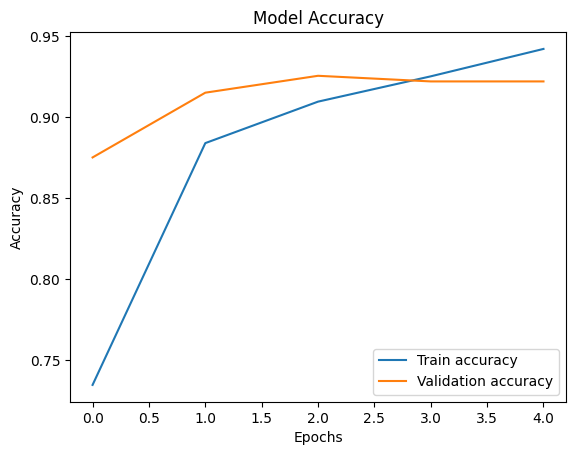

In [106]:
# Évaluation finale sur le jeu de validation
loss, accuracy = efficient_net_model.evaluate(test_dset)
print(f"Validation Accuracy: {accuracy:.2f}")

# Courbes de précision et de perte
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Found 33 files belonging to 3 classes.


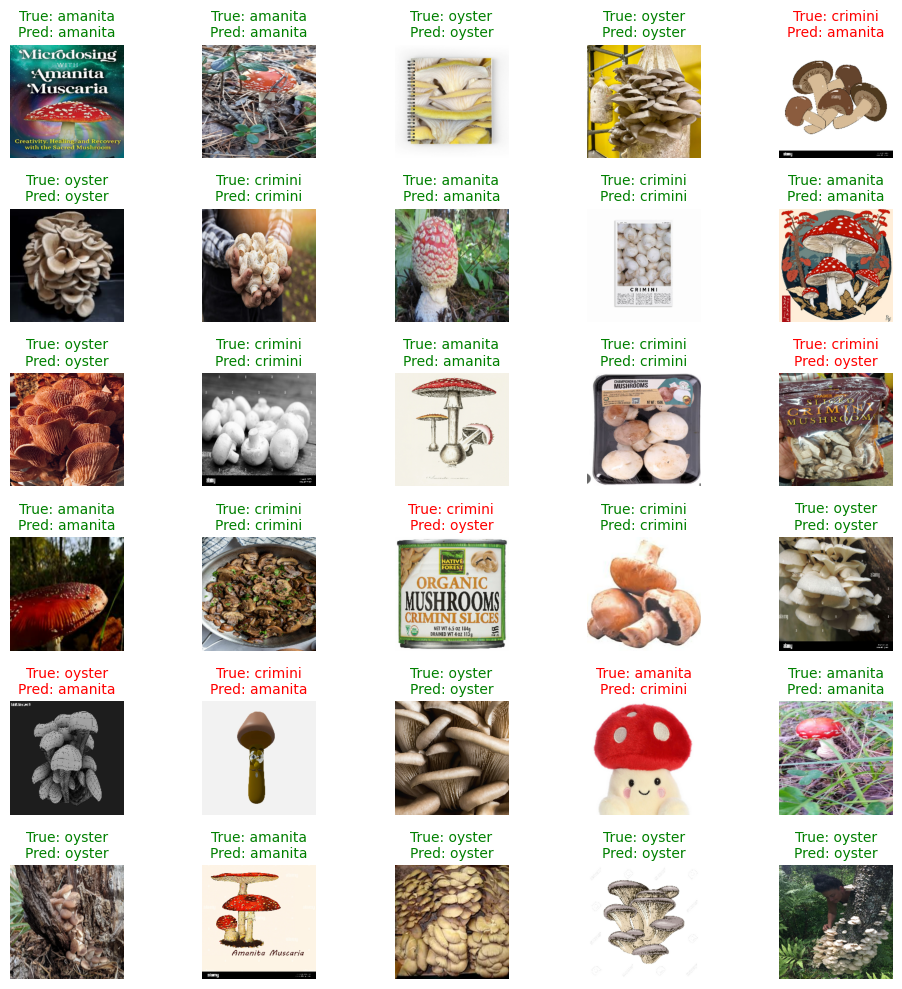

In [112]:
path = "tests"
test_dset_dir = pathlib.Path(path)

test_dset = tf.keras.utils.image_dataset_from_directory(
    test_dset_dir,
    shuffle=True,
    image_size=(img_height, img_width)
)

efficient_net_model = tf.keras.models.load_model("Model(KerasTuner).h5")
plot_images_grid_predicted_keras(test_dset, efficient_net_model, classes=class_names)

In [113]:
data = []
for layer in efficient_net_model.layers:
    weights = layer.get_weights()
    if weights:
        for i, w in enumerate(weights):
            data.append({"Layer Name": layer.name, "Weight n°": i+1, "Shape": w.shape})

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Optionally save to a CSV for further analysis
df.to_csv("efficient_net_model_weights.csv", index=False)

         Layer Name  Weight n°          Shape
0    efficientnetb0          1           (3,)
1    efficientnetb0          2           (3,)
2    efficientnetb0          3             ()
3    efficientnetb0          4  (3, 3, 3, 32)
4    efficientnetb0          5          (32,)
..              ...        ...            ...
311  efficientnetb0        312        (1280,)
312         dense_2          1     (1280, 64)
313         dense_2          2          (64,)
314         dense_3          1        (64, 3)
315         dense_3          2           (3,)

[316 rows x 3 columns]


### ``DenseNet121``

Nous avons par la suite décider d'utiliser le modèle ``DenseNet121`` afin de le comparer à nos deux précédents modèles.

``Pourquoi ce choix ?``

DenseNet introduit un mécanisme où chaque couche est directement connectée à toutes les couches précédentes. Comparé à d'autres modèles de classification comme ResNet,DenseNet121 est plus compact, nécessitant moins de paramètres.

Ceci est intéressant à tester car il y aurait moins de risque de surajustement, ce qui est bénéfique lorsque l'on travaille avec des données limitées de champignons.

 Selon le Wolfram Neural Net Repository, DenseNet121 atteint une précision top-1 de 75 % sur le jeu de validation original d'ImageNet. (https://resources.wolframcloud.com/NeuralNetRepository/resources/DenseNet-121-Trained-on-ImageNet-Competition-Data)

In [114]:
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in densenet_model.layers:
    layer.trainable = False

dense_net_model = Sequential([
    data_augmentation,
    densenet_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

dense_net_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [119]:
checkpoint = ModelCheckpoint("Model(DenseNet).h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

In [120]:
history = dense_net_model.fit(
    train_dset,
    validation_data=val_dset,
    epochs=5,
    callbacks=[checkpoint]
)

Epoch 1/5
 1/49 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - accuracy: 0.5625 - loss: 0.9463

C:\Users\reynalde\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6090 - loss: 0.9792 - val_accuracy: 0.6146 - val_loss: 1.0575
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6248 - loss: 0.9187 - val_accuracy: 0.6059 - val_loss: 1.1078
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6187 - loss: 0.9388 - val_accuracy: 0.6198 - val_loss: 0.9664
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.6408 - loss: 0.8673 - val_accuracy: 0.6250 - val_loss: 0.9830
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.6406 - loss: 0.8422 - val_accuracy: 0.6406 - val_loss: 1.0248


Found 33 files belonging to 3 classes.


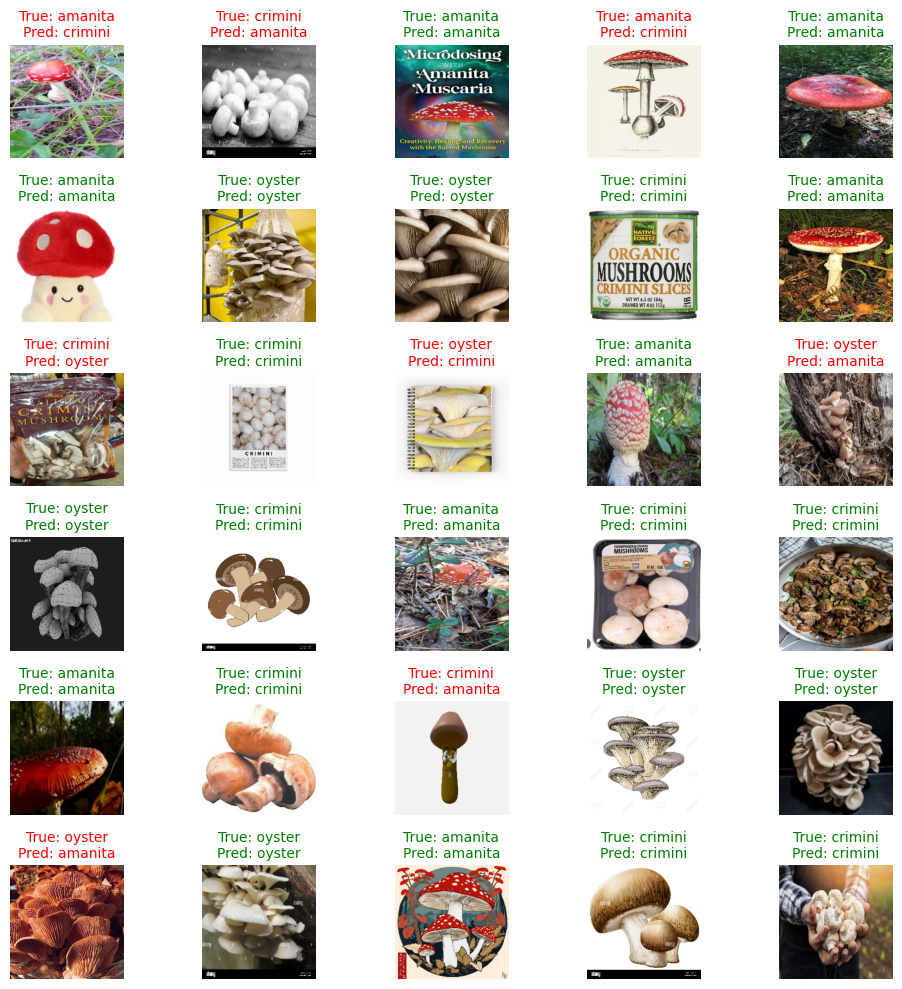

In [121]:
path = "tests"
test_dset_dir = pathlib.Path(path)

test_dset = tf.keras.utils.image_dataset_from_directory(
    test_dset_dir,
    shuffle=True,
    image_size=(img_height, img_width)
)

plot_images_grid_predicted_keras(test_dset, dense_net_model, classes=class_names)

In [122]:
data = []
for layer in dense_net_model.layers:
    weights = layer.get_weights()
    if weights:
        for i, w in enumerate(weights):
            data.append({"Layer Name": layer.name, "Weight n°": i+1, "Shape": w.shape})

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Optionally save to a CSV for further analysis
df.to_csv("dense_net_model_weights.csv", index=False)

      Layer Name  Weight n°          Shape
0    densenet121          1  (7, 7, 3, 64)
1    densenet121          2          (64,)
2    densenet121          3          (64,)
3    densenet121          4          (64,)
4    densenet121          5          (64,)
..           ...        ...            ...
603  densenet121        604        (1024,)
604      dense_4          1    (1024, 512)
605      dense_4          2         (512,)
606      dense_5          1       (512, 3)
607      dense_5          2           (3,)

[608 rows x 3 columns]


# Comparaison des modèles

In [123]:
# ResNet50
resnet_results = res_net_model.evaluate(test_dset, verbose=0)
print(f"ResNet50 - Loss: {resnet_results[0]:.4f}, Accuracy: {resnet_results[1]*100:.2f}%")

# Modèle obtenu avec KerasTuner
kt_results = efficient_net_model.evaluate(test_dset, verbose=0)
print(f"KerasTuner - Loss: {kt_results[0]:.4f}, Accuracy: {kt_results[1]*100:.2f}%")

#  DenseNet121
densenet_results = dense_net_model.evaluate(test_dset, verbose=0)
print(f"DenseNet121 - Loss: {densenet_results[0]:.4f}, Accuracy: {densenet_results[1]*100:.2f}%")


ResNet50 - Loss: 0.4345, Accuracy: 87.88%
KerasTuner - Loss: 0.3650, Accuracy: 81.82%
DenseNet121 - Loss: 0.7291, Accuracy: 75.76%


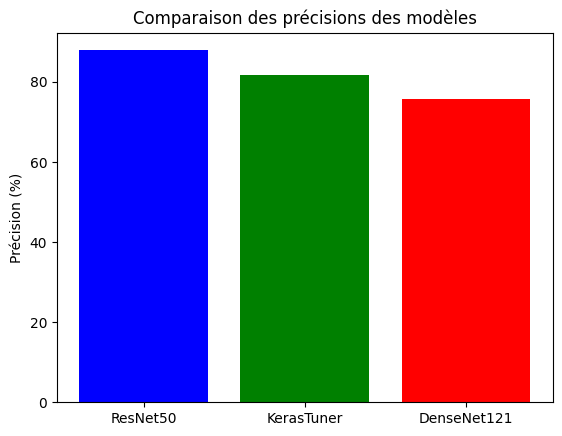

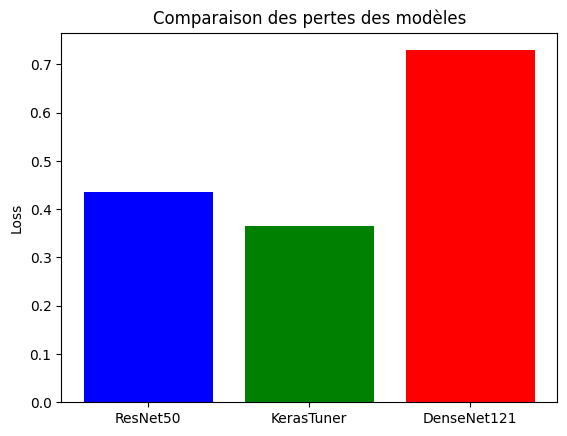

In [124]:
models = ['ResNet50', 'KerasTuner', 'DenseNet121']
accuracies = [resnet_results[1] * 100, kt_results[1] * 100, densenet_results[1] * 100]
losses = [resnet_results[0], kt_results[0], densenet_results[0]]

# Précision
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.title('Comparaison des précisions des modèles')
plt.ylabel('Précision (%)')
plt.show()

# Perte
plt.bar(models, losses, color=['blue', 'green', 'red'])
plt.title('Comparaison des pertes des modèles')
plt.ylabel('Loss')
plt.show()
